In [1]:
from tqdm import tqdm
from typing import List, Dict
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation,PacketFlowRepressentation,TimeslotRepresentation
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
import random
from flowprintOptimal.sekigo.flowUtils.flowDatasets import PacketFlowDataset, BaseFlowDataset, DDQNActivityDataset
from torch.utils.data import Dataset,DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import train_test_split
from flowprintOptimal.sekigo.flowUtils.commons import normalizePacketRep
import os
from joblib import Parallel, delayed
from flowprintOptimal.sekigo.flowUtils.commons import saveFlows,loadFlows
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import UTMobileNetProcessor
from flowprintOptimal.sekigo.flowUtils.dataGetterV2 import readTrainTestOODFlows
from sklearn.metrics import confusion_matrix
import json
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,TransformerGenerator,CNNNetwork1D, LSTMDuelingNetwork
from flowprintOptimal.sekigo.modeling.loggers import Logger
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder,State
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
from flowprintOptimal.sekigo.utils.documentor import Documenter
from flowprintOptimal.sekigo.utils.evaluations import Evaluator,EarlyEvaluation
from flowprintOptimal.sekigo.flowUtils.utils import readTrainTestOODFlows
import warnings
from copy import deepcopy
import torch.nn as nn

from flowprintOptimal.sekigo.earlyClassification.DQL.core import Rewarder

warnings.filterwarnings('ignore')

In [5]:
configs = dict(
    name = "deployment_ood",
    description = "deployment ood",
    
    common_config = dict(
        max_timesteps = 15,
        min_timesteps = 8
    ),
    
    full_model_kwargs = dict(
        lstm_hidden_size = 256,
        layers= 2, lstm_input_size = 3
    ),

    early_model_kwargs = dict(
        lstm_input_size= 3,lstm_hidden_size= 256,layers = 2                    
    ),
    
    data_config = dict(
        dataset_name = "deployment",
        subsampleConfig = None,#dict(max_gap = 20, min_gap = 5),                             
        max_flow_length = 100, # in seconds  ( each flow sample cannot excede this length)
        test_size = .2,
        ood_classes = ["hello"],
        do_balance = False,
        data_type = "packet_representation"

    ),

    rewarder_config = dict(
        l = .5
    ),

    dataset_config = dict(
        aug = [0,.2]
    ),

    memory_fillter_config = dict(
        ood_config = dict(ood_aug = [.6,.9], ood_prob = .2),
        min_length = 1,
        use_balancer = False
    ),
    full_trainer_config = dict(
        use_sampler = False
    ),
    early_trainer_config = dict(
        use_sampler = False  # this is for giving more weight to wait samples
    )

)

In [6]:
"""
# code to read and save packet flow reps UTMobileNet2021
utc_mobile_processor = UTMobileNetProcessor(base_path= "data/UTMobileNet2021")
flows = utc_mobile_processor.processData()
saveFlows(path  = "data/UTMobileNet2021/mobilenetPacketRep.json", flows = flows)
"""

'\n# code to read and save packet flow reps UTMobileNet2021\nutc_mobile_processor = UTMobileNetProcessor(base_path= "data/UTMobileNet2021")\nflows = utc_mobile_processor.processData()\nsaveFlows(path  = "data/UTMobileNet2021/mobilenetPacketRep.json", flows = flows)\n'

In [7]:
#train_flows, test_flows = loadFlows("Splits/Cls/UNIBS/train_flows.pkl", PacketFlowRepressentation), loadFlows("Splits/Cls/UNIBS/test_flows.pkl", PacketFlowRepressentation)
#ood_flows = []

In [8]:
#train_flows,test_flows,ood_flows = getTrainTestOOD(**configs["data_config"], max_timesteps= configs["common_config"]["max_timesteps"],
#                                                   min_timesteps= configs["common_config"]["min_timesteps"]
#                                                   )

In [9]:
if len(configs["data_config"]["ood_classes"]) == 0:
    base_dir_path = "data/ClassificationOnlyFlows"
else:
    base_dir_path = "data/ClassificationOODFlows"

In [10]:
train_packet_flows,test_packet_flows,ood_packet_flows, train_timeslot_flows,test_timeslot_flows,ood_timeslot_flows = readTrainTestOODFlows(base_path= base_dir_path, dataset_name= configs["data_config"]["dataset_name"])

data/ClassificationOODFlows/deployment


In [11]:
"""
def getTruncatePacketRep(flows : List[PacketFlowRepressentation], limit = 15):
    truncated_flows = []
    for flow in flows:
        if len(flow) <= limit:
            truncated_flows.append(flow)
        else:
            truncated_flows.append(flow.getSubFlow(0,limit))
    return truncated_flows



train_packet_flows = getTruncatePacketRep(flows= train_packet_flows)
test_packet_flows = getTruncatePacketRep(flows= test_packet_flows)
ood_packet_flows = getTruncatePacketRep(flows= ood_packet_flows)
"""

'\ndef getTruncatePacketRep(flows : List[PacketFlowRepressentation], limit = 15):\n    truncated_flows = []\n    for flow in flows:\n        if len(flow) <= limit:\n            truncated_flows.append(flow)\n        else:\n            truncated_flows.append(flow.getSubFlow(0,limit))\n    return truncated_flows\n\n\n\ntrain_packet_flows = getTruncatePacketRep(flows= train_packet_flows)\ntest_packet_flows = getTruncatePacketRep(flows= test_packet_flows)\nood_packet_flows = getTruncatePacketRep(flows= ood_packet_flows)\n'

In [12]:
if configs["data_config"]["data_type"] == "packet_representation":
    train_dataset = PacketFlowDataset(flows= train_packet_flows,label_to_index= None,aug= configs["dataset_config"]["aug"], truncate_length= 20)
    test_dataset = PacketFlowDataset(flows= test_packet_flows,label_to_index= train_dataset.label_to_index, truncate_length= 20)
    ood_dataset = PacketFlowDataset(flows= ood_packet_flows, label_to_index= None, truncate_length= 20) if (ood_packet_flows != None and len(ood_packet_flows) != 0) else None
    
    train_fixed_length_dataset = PacketFlowDataset(flows= train_packet_flows, label_to_index= None, aug= configs["dataset_config"]["aug"], fixed_length= 20)
    test_fixed_length_dataset = PacketFlowDataset(flows= test_packet_flows, label_to_index= train_fixed_length_dataset.label_to_index, aug= None, fixed_length= 20)
else:
    train_dataset = DDQNActivityDataset(flows= train_timeslot_flows,label_to_index= None, aug= configs["dataset_config"]["aug"])
    test_dataset = DDQNActivityDataset(flows= test_timeslot_flows,label_to_index= train_dataset.label_to_index)
    ood_dataset = DDQNActivityDataset(flows= ood_timeslot_flows, label_to_index= None) if (ood_timeslot_flows != None and len(ood_timeslot_flows) != 0) else None

    
    train_fixed_length_dataset = DDQNActivityDataset(flows= train_timeslot_flows, label_to_index= None, aug= configs["dataset_config"]["aug"], fixed_length= 12)
    test_fixed_length_dataset = DDQNActivityDataset(flows= test_timeslot_flows, label_to_index= train_fixed_length_dataset.label_to_index, aug= None, fixed_length= 12)

    configs["early_model_kwargs"]["lstm_input_size"] = 5
    configs["full_model_kwargs"]["lstm_input_size"] = 5


In [13]:
len(train_fixed_length_dataset), len(train_dataset), len(test_fixed_length_dataset), len(test_dataset)

(14683, 14683, 3671, 3671)

In [14]:
len(train_dataset), len(test_dataset), len(ood_dataset)

(14683, 3671, 953)

In [15]:
num_labels = len(train_dataset.label_to_index)
configs["full_model_kwargs"]["output_dim"] = num_labels 
configs["early_model_kwargs"]["output_dim"] = num_labels + 1
configs["rewarder_config"]["num_labels"] = num_labels
configs["rewarder_config"]["max_length"] = configs["common_config"]["max_timesteps"]

In [47]:
#classifier_ = CNNNetwork1D( **configs["full_model_kwargs"])#LSTMNetwork(lstm_hidden_size= 64,lstm_input_size=6,output_dim = len(all_train_dataset.label_to_index))
classifier_ = LSTMNetwork(**configs["full_model_kwargs"])
logger= Logger(name= "classification",verbose= True)
logger.default_step_size = 500
classification_trainer = NNClassificationTrainer(classifier = classifier_,device= device,logger= logger)
classification_trainer.train(train_dataset= train_fixed_length_dataset,test_dataset= test_fixed_length_dataset,epochs=500,batch_size= 64,lr= .0003,use_balanced_sampler= configs["full_trainer_config"]["use_sampler"])

classification ---- 1 metric test_f1 = 0.02909000497265042
classification ---- 1 metric test_accuracy = 0.09561427403977119
classification ---- 1 metric train_accuracy = 0.0962337396989716
classification ---- 1 metric train_f1 = 0.029261928429423458
classification ---- 10 metric train_loss = 1.7767736673355103
classification ---- 20 metric train_loss = 1.6800177216529846
classification ---- 30 metric train_loss = 1.6355953216552734
classification ---- 40 metric train_loss = 1.619344663619995
classification ---- 50 metric train_loss = 1.5584908604621888
classification ---- 60 metric train_loss = 1.5518067240715028
classification ---- 70 metric train_loss = 1.5921908259391784
classification ---- 80 metric train_loss = 1.5603059649467468
classification ---- 90 metric train_loss = 1.496107029914856
classification ---- 100 metric train_loss = 1.4431887149810791
classification ---- 110 metric train_loss = 1.3940611600875854
classification ---- 120 metric train_loss = 1.3391949653625488
class

KeyboardInterrupt: 

In [48]:
classification_trainer.best["score"]
Evaluator(model= classification_trainer.best["model"], device=device).getMetrices(dataset= test_fixed_length_dataset)

{'micro_f1': 0.09561427403977119,
 'macro_f1': 0.02909000497265042,
 'accuracy': 0.09561427403977119,
 'cm': array([[   0,  884,    0,    0,    0,    0],
        [   0,  351,    0,    0,    0,    0],
        [   0,  592,    0,    0,    0,    0],
        [   0, 1109,    0,    0,    0,    0],
        [   0,  698,    0,    0,    0,    0],
        [   0,   37,    0,    0,    0,    0]]),
 'per_class_f1': array([0.        , 0.17454003, 0.        , 0.        , 0.        ,
        0.        ])}

In [49]:
device

device(type='cuda')

In [50]:
from flowprintOptimal.sekigo.flowUtils.packetDropping import getPacketDroppedPacketDataset
dropped_test_dataset = getPacketDroppedPacketDataset(packet_dataset= test_dataset, max_drop_rate= .3)
test_dropped_fixed_length_dataset = PacketFlowDataset(flows= dropped_test_dataset.flows, label_to_index= train_fixed_length_dataset.label_to_index, aug= None, fixed_length= 20)
Evaluator(model= classification_trainer.best["model"], device=torch.device("cpu")).getMetrices(dataset= test_dropped_fixed_length_dataset)

{'micro_f1': 0.09561427403977119,
 'macro_f1': 0.02909000497265042,
 'accuracy': 0.09561427403977119,
 'cm': array([[   0,  884,    0,    0,    0,    0],
        [   0,  351,    0,    0,    0,    0],
        [   0,  592,    0,    0,    0,    0],
        [   0, 1109,    0,    0,    0,    0],
        [   0,  698,    0,    0,    0,    0],
        [   0,   37,    0,    0,    0,    0]]),
 'per_class_f1': array([0.        , 0.17454003, 0.        , 0.        , 0.        ,
        0.        ])}

In [52]:
rewarder = Rewarder(**configs["rewarder_config"])
memory_filler = MemoryFiller(dataset= train_dataset,rewarder= rewarder, min_length= configs["memory_fillter_config"]["min_length"],
                              max_length= rewarder.max_length,ood_config= configs["memory_fillter_config"]["ood_config"], use_balancer= configs["memory_fillter_config"]["use_balancer"]
                              )

In [53]:
memory = memory_filler.processDataset()
print(len(memory))

4111240


In [54]:
memory_dataset = MemoryDataset(memories= memory,num_classes= len(train_dataset.label_to_index),
                               min_length= memory_filler.min_length,max_length= memory_filler.max_length)
predictor = LSTMDuelingNetwork(**configs["early_model_kwargs"])
logger = Logger(verbose= True)
logger.default_step_size = 1000

In [55]:
labels = []

for m in memory_dataset:
    labels.append(m["label"])

print(pd.Series(labels).value_counts())

 3    1079680
 0     898520
 4     723520
 2     602420
-1     416640
 1     355880
 5      34580
Name: count, dtype: int64


In [56]:
ddq_model = EarlyClassificationtrainer(predictor= predictor,train_dataset = train_dataset,test_dataset= test_dataset,memory_dataset= memory_dataset,
                                       ood_dataset= ood_dataset,use_sampler= configs["early_trainer_config"]["use_sampler"],
                                       logger= logger,device=device,model_replacement_steps= 500)

In [57]:
ddq_model.train(epochs= 20,batch_size= 128,lr= .0003,lam= .99)  

 ---- 1000 metric q_loss = 0.4230676413029432
 ---- 1 metric test_eval_f1 = 0.11933806146572104
 ---- 1 metric test_eval_time = 10.413746630727763
 ---- 1 metric incorrect_ood_test = 0.5957504767093436
 ---- 1 metric ood_eval = 0.7660020986358866
 ---- 1 metric ood_eval_time = 17.948583420776494
 ---- 2000 metric q_loss = 0.4011082411408424
 ---- 2 metric test_eval_f1 = 0.3182225643800843
 ---- 2 metric test_eval_time = 11.59400676655389
 ---- 2 metric incorrect_ood_test = 0.4363933533097249
 ---- 2 metric ood_eval = 0.8132214060860441
 ---- 2 metric ood_eval_time = 18.60335781741868
 ---- 1 metric train_eval_f1 = 0.3138078817140036
 ---- 1 metric train_eval_time = 11.791070762342992
 ---- 1 metric incorrect_ood_train = 0.452359871960771
 ---- 3000 metric q_loss = 0.39179618211090567
 ---- 3 metric test_eval_f1 = 0.27239399332604336
 ---- 3 metric test_eval_time = 10.156391953277092
 ---- 3 metric incorrect_ood_test = 0.16044674475619722
 ---- 3 metric ood_eval = 0.8887722980062959
 --

KeyboardInterrupt: 

In [58]:
configs["name"] 

'deployment_ood'

In [60]:
configs["name"] = "deployment_ood"

In [61]:
documenter = Documenter(train_dataset= train_dataset,test_dataset= test_dataset, ood_dataset = ood_dataset,full_model= classification_trainer.best["model"], early_model= ddq_model.best["model"],
                        configs= configs
                        )

In [62]:
documenter.document(name= configs["name"])

In [63]:
test_dataset.label_to_index, len(test_dataset)

({'Video': 0,
  'Mail': 1,
  'Download': 2,
  'Software Update': 3,
  'File Storage': 4,
  'Conferencing': 5},
 3671)

In [28]:
EarlyEvaluation(min_steps= 1,device= device,model= ddq_model.best["model"]).getMetrices(dataset= test_dataset,ood_dataset= ood_dataset)

{'micro_f1': 0.8502902535899786,
 'macro_f1': 0.8464111516427878,
 'accuracy': 0.8502902535899786,
 'cm': array([[464,  51,  28,  62],
        [ 46, 761,  16,  67],
        [ 44,   9, 660,  31],
        [ 32,  90,  14, 898]]),
 'per_class_f1': array([0.77917716, 0.84508606, 0.90287278, 0.8585086 ]),
 'time': 26.06355025970058,
 'time_std': 45.345423012582366,
 'incorrect_ood': 0.003045994517209869,
 'ood_accuracy': 0.6326693227091633,
 'ood_time': 20.650996015936254}

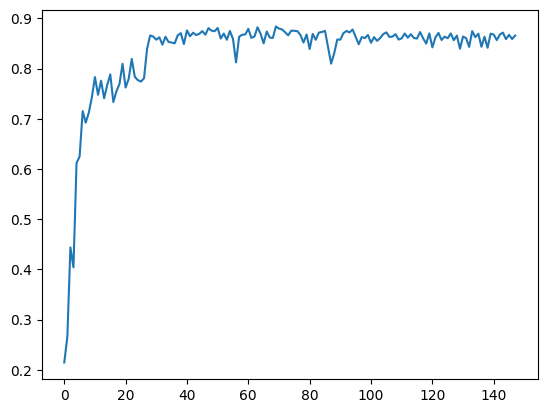

In [30]:
plt.plot(logger.getMetric("test_eval_f1"))

In [ ]:
res = ddq_model.eval(dataset= test_dataset)
res

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
preds = ddq_model.predictOnDataset(dataset= test_dataset)
preds = np.array(preds)[:,0]
labels = list(map(lambda x : x["label"], test_dataset))

In [ ]:
preds[(preds == -1)] = 0

In [ ]:
test_dataset.label_to_index

{'BROWSERS': 0, 'P2P': 1, 'OTHER': 2, 'Skype': 3, 'MAIL': 4}

In [ ]:


confusion_matrix(y_true= labels,y_pred= preds)

array([[1796,    6,  302,  347,    6],
       [  23, 2398,   17,    8,    8],
       [ 501,   10, 1258,  209,   21],
       [ 195,   12,   63, 1811,    3],
       [  66,   13,   22,   16, 1113]])

In [ ]:
test_dataset.label_to_index
index_to_label = {x:y for y,x in test_dataset.label_to_index.items()}

In [ ]:
labels = np.array(test_dataset.get_labels())
unique_labels = np.unique(labels)
res = ddq_model.predictOnDataset(test_dataset)
res = np.array(res)[:,1]

In [ ]:
ut_dct = dict()
for label in unique_labels:
    ut_dct[index_to_label[label]] =  res[labels == label].mean()

In [ ]:
ut_dct

{'google-maps': 9.732919254658386,
 'youtube': 11.95539033457249,
 'instagram': 12.003968253968255,
 'pinterest': 9.855371900826446,
 'spotify': 11.63953488372093,
 'facebook': 11.846456692913385,
 'google-drive': 8.884146341463415,
 'twitter': 10.19186046511628,
 'netflix': 9.655581947743467,
 'reddit': 11.238235294117647,
 'hangout': 8.974025974025974,
 'messenger': 12.655913978494624,
 'gmail': 11.673684210526316}

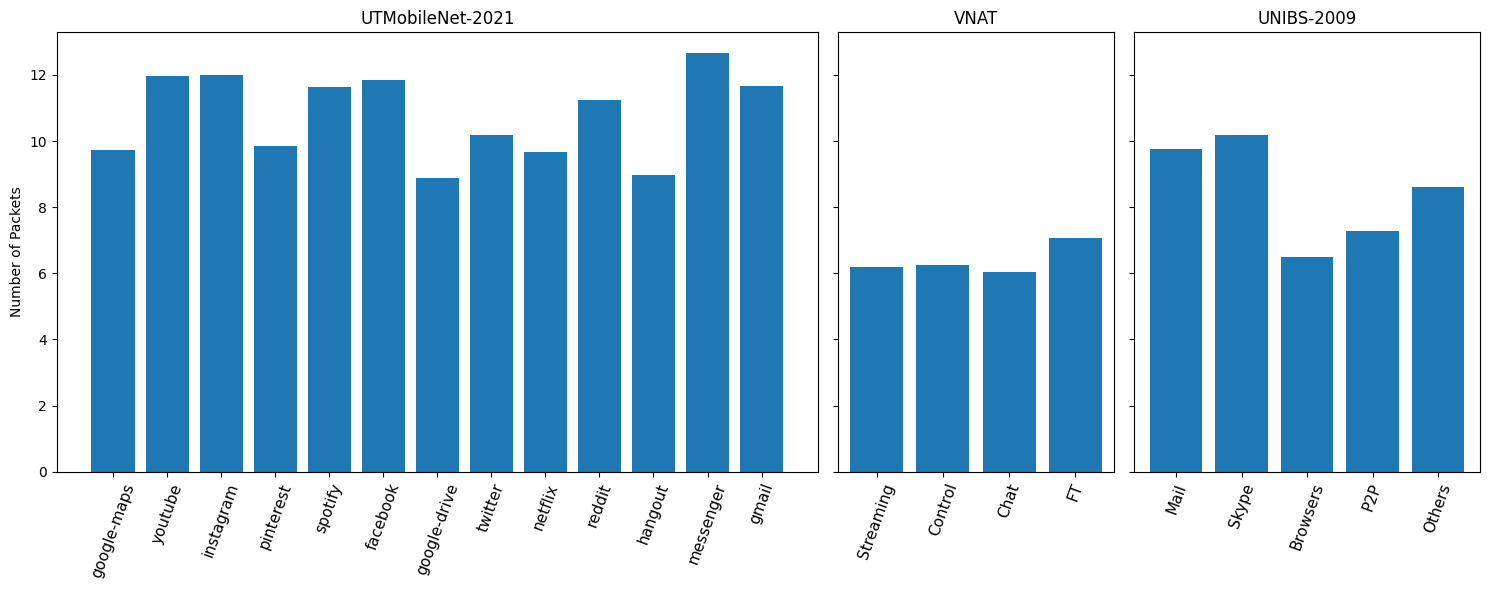

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def getDataDct(dct):
    X,y = [],[]
    for key,value in dct.items():
        X.append(key)
        y.append(value)
    return X,y
# Sample data for 4 datasets, each containing classes and corresponding values
class_data = {
    'UTMobileNet-2021': ut_dct,
    'VNAT': {'Streaming': 6.19, 'Control': 6.25, 'Chat': 6.05, 'FT': 7.07},
    'UNIBS-2009': {'Mail': 9.75, 'Skype': 10.17, 'Browsers': 6.48, 'P2P': 7.28, 'Others': 8.62},
}



f, axes = plt.subplots(1, len(class_data), sharex='col', sharey='row', figsize=(15, 6),gridspec_kw={'width_ratios':[11,4,5]})

for i,dataset in enumerate(class_data):
    X,y = getDataDct(class_data[dataset])
    axes[i].bar(X,y)
    axes[i].set_title(dataset)
    axes[i].tick_params(axis='x', rotation=70,labelsize = 11)
    if i == 0:
        axes[i].set_ylabel('Number of Packets')  # Set y-axis label



plt.tight_layout()
plt.show()


In [ ]:
res[labels == 0].mean()

9.732919254658386

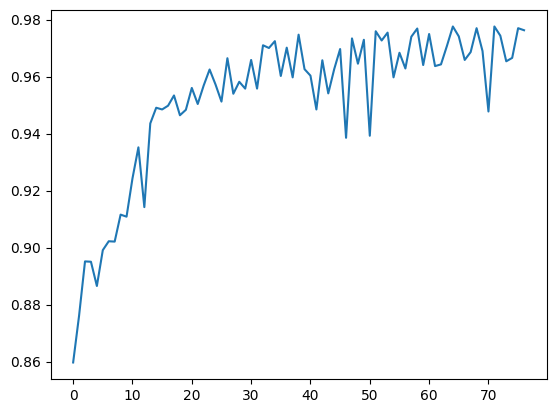

In [ ]:
plt.plot(logger.getMetric("test_eval_f1"))

In [ ]:
np.argmax(np.array(logger.getMetric(metric_name= "test_eval_f1")))

64

In [ ]:
logger.getMetric(metric_name= "test_eval_time")[64]

7.814477468839885

In [ ]:
logger.getMetric(metric_name= "test_eval_f1")[64]

0.9775886864813039